In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
import json

TSNE_FILE = "2dTSNE.json"
PERCEPTUAL_FILE = "raga_similarity_perceptual.csv"

def load_tsne_coords(tsne_file):
    with open(tsne_file) as f:
        data = json.load(f)
    raga_to_coord = {entry["raga"]: (entry["x"], entry["y"]) for entry in data}
    return raga_to_coord

def intersect_ragas(tsne_coords, perceptual_df):
    tsne_ragas = set(tsne_coords.keys())
    perceptual_ragas = set(perceptual_df.index)
    common = sorted(tsne_ragas & perceptual_ragas)
    return common

perceptual_df = pd.read_csv(PERCEPTUAL_FILE, index_col=0)
tsne_coords = load_tsne_coords(TSNE_FILE)
ragas = intersect_ragas(tsne_coords, perceptual_df)
print(f"Common ragas: {len(ragas)}")

Common ragas: 95


In [22]:
DATA_FILE = "2dTSNE.json"

In [23]:
df = pd.read_json(DATA_FILE)

df["source"] = df["raga"].str.split("_").str[0]
df["source_raga"] = df["raga"]
df["raga"] = df["raga"].str.split("_").str[1]

df["seq_octaveless"] = df["seq"].str.replace(".", "").str.replace("'", "")

df["seq_len"] = df["seq"].str.len()

df.head()

# keep only ragas in 'ragas'
df = df[df["source_raga"].isin(ragas)]

# reindex
df = df.set_index("raga")

df.head()

,x,y,seq,source,source_raga,seq_octaveless,seq_len
raga,,,,,,,
bairagi,-5.085607,-25.645140,sRmpmpNpmRRpmRs.NsRssRmpN's'sNpmRs.NsRmpNmNpNp...,H,H_bairagi,sRmpmpNpmRRpmRsNsRssRmpNssNpmRsNsRmpNmNpNpmpmR...,369
bhatiyar,21.433535,-13.455523,smpdmssmppgRssdndnpdmpgpgRsMd'ssRssmmdpsddnpmp...,H,H_bhatiyar,smpdmssmppgRssdndnpdmpgpgRsMdssRssmmdpsddnpmpg...,148
bhoopali,-11.075260,16.039610,srgpdssdpgrssdsrgpgdpgrssdpgrsrgpgdpggpdsrsdps...,H,H_bhoopali,srgpdssdpgrssdsrgpgdpgrssdpgrsrgpgdpggpdsrsdps...,7937
bihag,-15.197196,3.700889,nsgmpnssndpMpgmgrsnsgmpMpgmgrsppgmgsnnpnnsggmp...,H,H_bihag,nsgmpnssndpMpgmgrsnsgmpMpgmgrsppgmgsnnpnnsggmp...,1598
bilaskhani todi,5.082459,-22.930182,sGpDDpGssR.N.DssRGRGppDNDDmGRGRssRGpD's's'RNDp...,H,H_bilaskhani todi,sGpDDpGssRNDssRGRGppDNDDmGRGRssRGpDssRNDppDNDm...,1373


In [24]:
def get_vectors(seq):
	from tokenize_seq import tokenize_seq
	from sklearn.feature_extraction.text import TfidfVectorizer

	# Initialize TF-IDF Vectorizer
	vectorizer = TfidfVectorizer(tokenizer=tokenize_seq, lowercase=False, ngram_range=(3,5))

	# Fit and transform the sequences
	X = vectorizer.fit_transform(seq)

	# Convert TF-IDF matrix to dense array
	X_array = X.toarray()

	print(X_array.shape)
	return X_array

X_array = get_vectors(df["seq"])
df["X_array"] = list(X_array)

(95, 40675)


/home/soham/miniconda3/envs/csai/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
def get_short_seq(seq):
	"""
		const SEQ_SIZE = 16;
		// get a random subsequence of SEQ_SIZE from the raga
		const seq = ragaDB[ragaName];
		const start = Math.floor(Math.random() * (seq.length - SEQ_SIZE));
		const end = start + SEQ_SIZE;
		const subseq = seq.slice(start, end);
	"""
	SEQ_SIZE = 16
	start = np.random.randint(0, len(seq) - SEQ_SIZE)
	end = start + SEQ_SIZE
	subseq = seq[start:end]
	return subseq

df["short_seq"] = df["seq"].apply(get_short_seq)
short_X_array = get_vectors(df["short_seq"])
df["short_X_array"] = list(short_X_array)

(95, 2156)


/home/soham/miniconda3/envs/csai/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

def analyze_tfidf_comparison(df, k=5, top_n=10):
    from tokenize_seq import tokenize_seq
    # Step 1: Build shared TF-IDF vectorizer
    all_seqs = df['seq'].tolist() + df['short_seq'].tolist()
    vectorizer = TfidfVectorizer(tokenizer=tokenize_seq, ngram_range=(3, 5), lowercase=False)
    vectorizer.fit(all_seqs)

    # Step 2: Transform both using same vectorizer
    X_full = vectorizer.transform(df['seq'].tolist())
    X_short = vectorizer.transform(df['short_seq'].tolist())

    df["X_full"] = list(X_full)
    df["X_short"] = list(X_short)

    # 1. Cosine similarity between full and short
    self_sims = cosine_similarity(X_full, X_short).diagonal()
    df['cosine_similarity'] = self_sims
    print("\n--- Cosine Similarity Between Full and Short TF-IDF ---")
    print(f"Mean: {np.mean(self_sims):.4f}")
    print(f"Median: {np.median(self_sims):.4f}")
    print(f"Min: {np.min(self_sims):.4f}")
    print(f"Max: {np.max(self_sims):.4f}")

    # 2. Neighbor overlap
    sim_full = cosine_similarity(X_full)
    sim_short = cosine_similarity(X_short)

    neighbor_overlap = []
    for i in range(len(df)):
        top_full = set(np.argsort(sim_full[i])[::-1][1:k+1])
        top_short = set(np.argsort(sim_short[i])[::-1][1:k+1])
        overlap = len(top_full & top_short) / k
        neighbor_overlap.append(overlap)

    df['neighbor_overlap@k'] = neighbor_overlap
    print(f"\n--- Top-{k} Neighbor Overlap ---")
    print(f"Mean: {np.mean(neighbor_overlap):.4f}")
    print(f"Median: {np.median(neighbor_overlap):.4f}")

    # # 3. Top-n n-gram overlap (still based on separate TF-IDFs)
    # ngram_overlap = []
    # for i in range(len(df)):
    #     full_feats = vectorizer.transform([df.loc[i, 'seq']]).toarray()[0]
    #     short_feats = vectorizer.transform([df.loc[i, 'short_seq']]).toarray()[0]

    #     top_full = set(np.argsort(full_feats)[::-1][:top_n])
    #     top_short = set(np.argsort(short_feats)[::-1][:top_n])
    #     overlap = len(top_full & top_short) / top_n
    #     ngram_overlap.append(overlap)

    # df[f'ngram_overlap@top{top_n}'] = ngram_overlap
    # print(f"\n--- Top-{top_n} TF-IDF N-gram Index Overlap ---")
    # print(f"Mean: {np.mean(ngram_overlap):.4f}")
    # print(f"Median: {np.median(ngram_overlap):.4f}")

    return df, X_full, X_short

results, X_full, X_short = analyze_tfidf_comparison(df, k=5, top_n=10)

/home/soham/miniconda3/envs/csai/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- Cosine Similarity Between Full and Short TF-IDF ---
Mean: 0.3158
Median: 0.2811
Min: 0.0322
Max: 0.7535

--- Top-5 Neighbor Overlap ---
Mean: 0.2211
Median: 0.2000


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

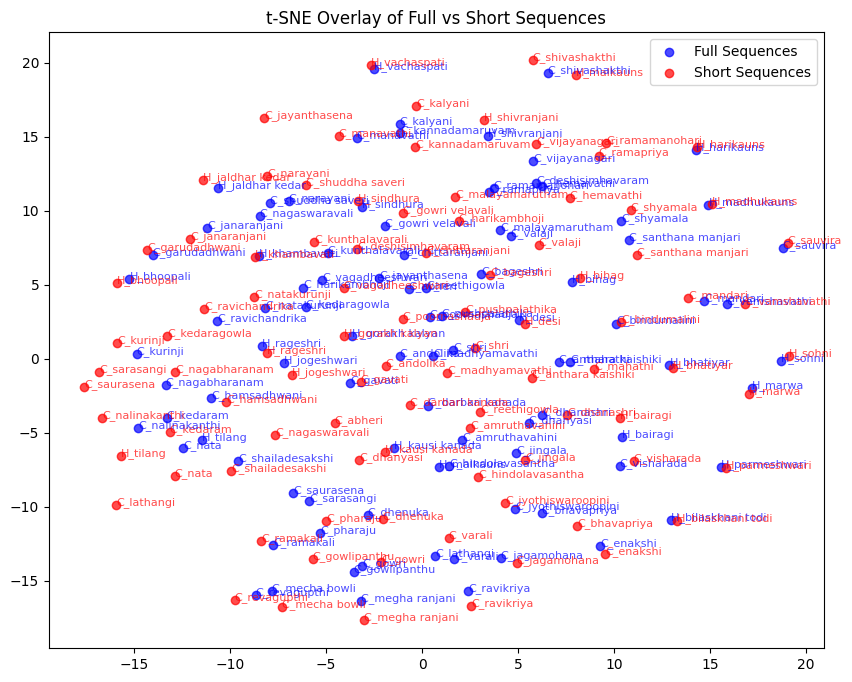

In [28]:
def tsne_overlay(X_full, X_short, labels):
    combined = np.vstack([X_full.toarray(), X_short.toarray()])
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    combined_embedded = tsne.fit_transform(combined)

    n = X_full.shape[0]
    full_embedded = combined_embedded[:n]
    short_embedded = combined_embedded[n:]

    plt.figure(figsize=(10, 8))
    plt.scatter(full_embedded[:, 0], full_embedded[:, 1], c='blue', label='Full Sequences', alpha=0.7)
    plt.scatter(short_embedded[:, 0], short_embedded[:, 1], c='red', label='Short Sequences', alpha=0.7)

    for i, label in enumerate(labels):
        plt.text(full_embedded[i, 0], full_embedded[i, 1], label, fontsize=8, color='blue', alpha=0.7)
        plt.text(short_embedded[i, 0], short_embedded[i, 1], label, fontsize=8, color='red', alpha=0.7)

    plt.title("t-SNE Overlay of Full vs Short Sequences")
    plt.legend()
    plt.show()

tsne_overlay(X_full, X_short, df['source_raga'].tolist())


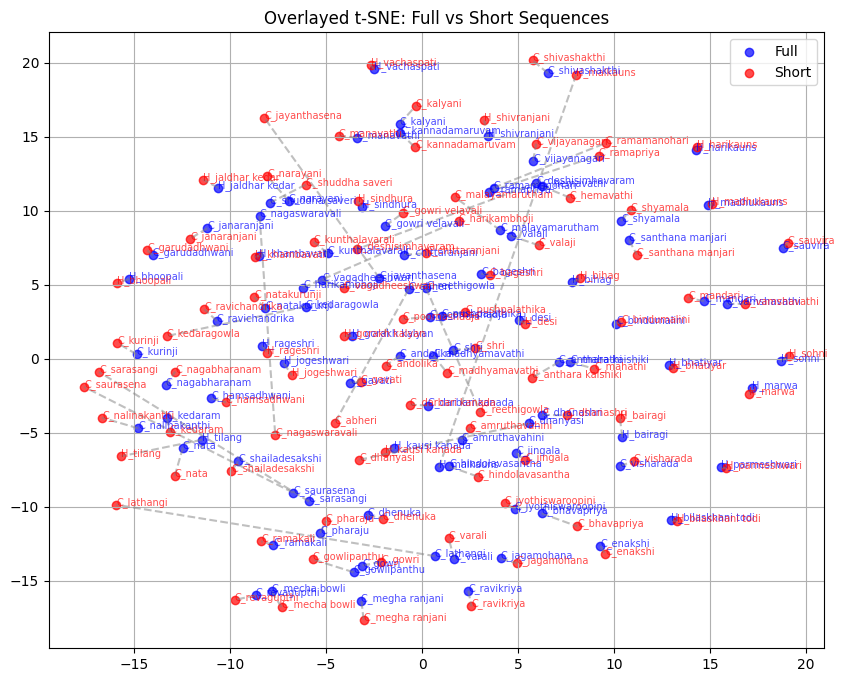

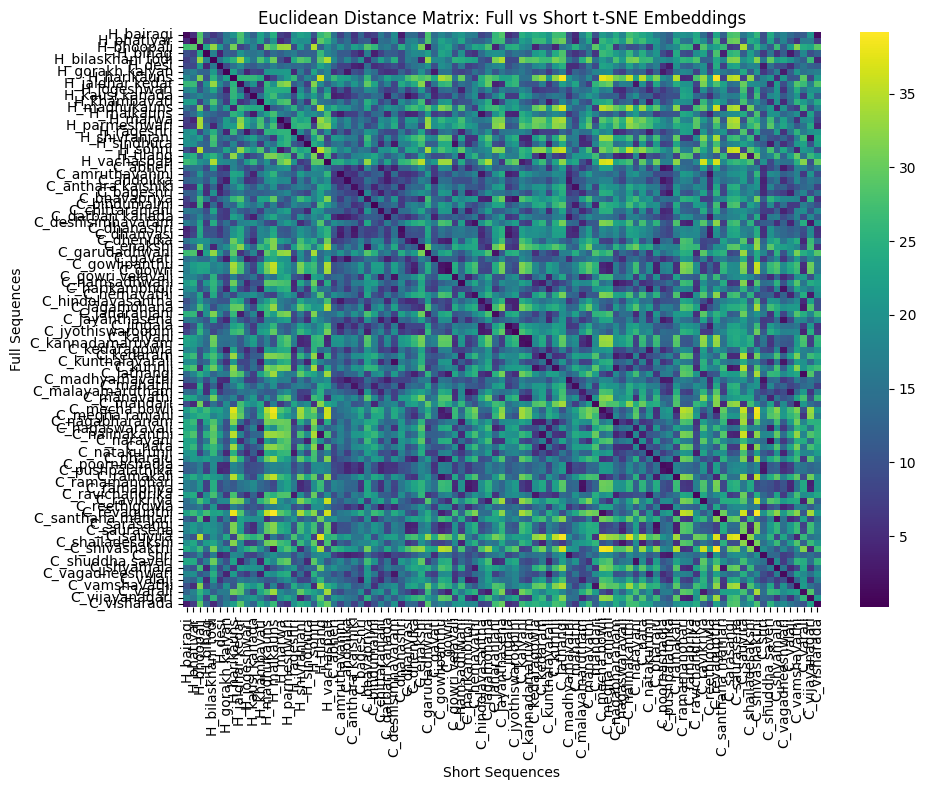

In [29]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

def overlay_tsne_and_distance_matrix(X_full, X_short, labels, perplexity=30, random_state=42):
    # Step 1: Combine TF-IDF vectors
    combined = np.vstack([X_full.toarray(), X_short.toarray()])
    
    # Step 2: Run t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embedded = tsne.fit_transform(combined)

    n = X_full.shape[0]
    full_emb = embedded[:n]
    short_emb = embedded[n:]

    # Step 3: Overlay visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(full_emb[:, 0], full_emb[:, 1], color='blue', label='Full', alpha=0.7)
    plt.scatter(short_emb[:, 0], short_emb[:, 1], color='red', label='Short', alpha=0.7)

    for i, label in enumerate(labels):
        plt.plot([full_emb[i, 0], short_emb[i, 0]], [full_emb[i, 1], short_emb[i, 1]], color='gray', linestyle='--', alpha=0.5)
        plt.text(full_emb[i, 0], full_emb[i, 1], label, fontsize=7, color='blue', alpha=0.7)
        plt.text(short_emb[i, 0], short_emb[i, 1], label, fontsize=7, color='red', alpha=0.7)

    plt.title("Overlayed t-SNE: Full vs Short Sequences")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 4: Compute distance matrix between full and short t-SNE embeddings
    dist_matrix = cdist(full_emb, short_emb, metric='euclidean')  # shape (n, n)

    # Step 5: Visualize as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_matrix, xticklabels=labels, yticklabels=labels, cmap="viridis", annot=False)
    plt.title("Euclidean Distance Matrix: Full vs Short t-SNE Embeddings")
    plt.xlabel("Short Sequences")
    plt.ylabel("Full Sequences")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return dist_matrix
distance_matrix = overlay_tsne_and_distance_matrix(X_full, X_short, df['source_raga'].tolist())


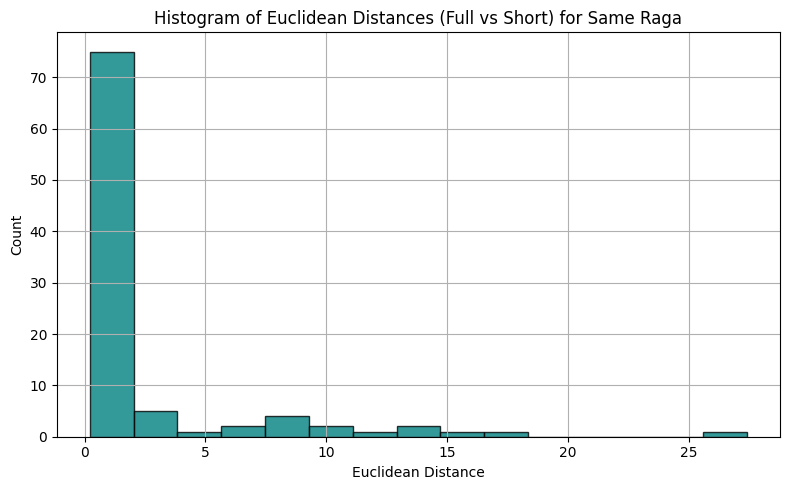

In [31]:
def plot_same_raga_distance_histogram(dist_matrix, labels):
    import matplotlib.pyplot as plt
    import numpy as np

    # Get the diagonal distances: same-raga full vs short
    same_raga_distances = np.diag(dist_matrix)

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(same_raga_distances, bins=15, color='teal', edgecolor='black', alpha=0.8)
    plt.title("Histogram of Euclidean Distances (Full vs Short) for Same Raga")
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: return values for further inspection
    return same_raga_distances
same_raga_dists = plot_same_raga_distance_histogram(distance_matrix, df['source_raga'].tolist())
